In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch = 128 # batch size (change to ensure GPU occupay)
coded_channels = 8 # channels of the output of encoder
learning_rate = 1e-3
dorpout_p = 0.5

# load weight from .pth file
pretrained = False

# get the device to run
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Selected device: cuda


In [3]:
# load FashinMNIST data
training_data = torchvision.datasets.FashionMNIST(
    root="Fashion_MNIST_data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root="Fashion_MNIST_data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [4]:
# define NN's struct
class Encoder(torch.nn.Module):
    def __init__(self, mid_channels = 32):
        super(Encoder, self).__init__()

        kernel_size = 3
        pool_size = 2
        self.conv1 = torch.nn.Conv2d(1, mid_channels, kernel_size, padding=1)
        self.conv2 = torch.nn.Conv2d(mid_channels, coded_channels, kernel_size, padding=1)
        self.bn = torch.nn.BatchNorm2d(coded_channels)
        self.pool = torch.nn.MaxPool2d(pool_size, pool_size)
    
    def forward(self, x):
        # first layer
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool(x)
        # 14 x 14 x mid_channels

        # second layer
        x = self.conv2(x)
        x = self.bn(x) # Batch Normlize
        x = torch.nn.functional.relu(x)
        x = self.pool(x)
        # 7 x 7 x coded_channels

        return x

class Decoder(torch.nn.Module):
    def __init__(self, mid_channels = 32):
        super(Decoder, self).__init__()

        kernel_size = 2
        self.t_conv1 = torch.nn.ConvTranspose2d(coded_channels, mid_channels, kernel_size, stride=2)
        self.t_conv2 = torch.nn.ConvTranspose2d(mid_channels, 1, kernel_size, stride=2)

    def forward(self, x):
        #first layer
        x = self.t_conv1(x)
        x = torch.nn.functional.relu(x)
        # 14 x 14 x mid_channels

        #second layer
        x = self.t_conv2(x)
        x = torch.sigmoid(x) # ensure ouput is in [0, 1]
        # 28 x 28 x 1

        return x

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.seq = torch.nn.Sequential(
            torch.nn.Linear(7*7*coded_channels, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(dorpout_p),

            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(dorpout_p),
            
            torch.nn.Linear(64, len(classes)), # since we are using Cross Entropy, no need for softmax
        )

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.seq(x)
        return logits

encoder = Encoder()
decoder = Decoder()
classifier = Classifier()

# load weights from .pth
if pretrained:
    encoder.load_state_dict(torch.load('encoder_weight.pth'))
    decoder.load_state_dict(torch.load('decoder_weight.pth'))
    classifier.load_state_dict(torch.load('classifier_weight.pth'))

# copy models to device
encoder.to(device)
decoder.to(device)
classifier.to(device)

Classifier(
  (seq): Sequential(
    (0): Linear(in_features=392, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [56]:
def ae_train_epoch(encoder, decoder, device, dataloader, loss_fn, optim):
    encoder.train()
    decoder.train()

    train_loss = []

    for inputs, _ in dataloader:
        inputs = inputs.to(device)

        coded = encoder(inputs)
        outputs = decoder(coded)

        loss = loss_fn(inputs, outputs)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def ae_test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()

    test_loss = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            
            coded = encoder(inputs)
            outputs = decoder(coded)

            loss = loss_fn(inputs, outputs)

            test_loss.append(loss.detach().cpu().numpy())
    
    return np.mean(test_loss)       

def ae_plot(encoder, decoder, dataset, device, r=1):
    encoder.eval()
    decoder.eval()

    n = len(classes)
    
    labels = dataset.targets.numpy()
    idx = {i: np.where(labels == i)[0][:r] for i in range(n)}

    _, axes = plt.subplots(nrows=2*r, ncols=n, sharex=True, sharey=True, figsize=(2.5*n,2.1*2*r))
    for r, row in zip(range(2*r), axes):
        for i, ax in zip(range(n), row):
            if r % 2 == 0:
                ax.set_title(classes[i])
                ax.imshow(np.squeeze(dataset[idx[i][r//2]][0].numpy()), cmap='gray')
            else:
                img = dataset[idx[i][r//2]][0].unsqueeze(0).to(device)
                with torch.no_grad():
                    out = decoder(encoder(img))
                    ax.imshow(np.squeeze(out.detach().cpu().numpy()), cmap='gray')

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()


In [6]:
ae_params = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

ae_loss = torch.nn.MSELoss()
ae_optim = torch.optim.Adam(ae_params, lr=learning_rate)

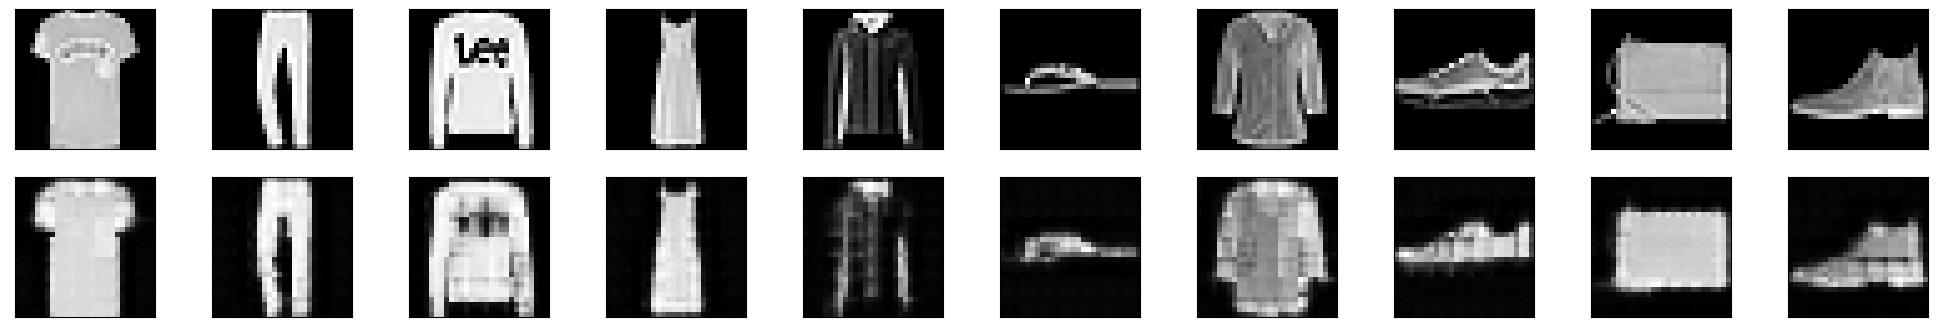

Epoch:   1/128, Training Epoch avg. Loss: 0.018786, Testing Loss: 0.009830
Epoch:   2/128, Training Epoch avg. Loss: 0.009325, Testing Loss: 0.008739
Epoch:   3/128, Training Epoch avg. Loss: 0.008567, Testing Loss: 0.008152
Epoch:   4/128, Training Epoch avg. Loss: 0.008084, Testing Loss: 0.007717
Epoch:   5/128, Training Epoch avg. Loss: 0.007730, Testing Loss: 0.007399
Epoch:   6/128, Training Epoch avg. Loss: 0.007442, Testing Loss: 0.007131
Epoch:   7/128, Training Epoch avg. Loss: 0.007196, Testing Loss: 0.006923
Epoch:   8/128, Training Epoch avg. Loss: 0.006991, Testing Loss: 0.006757
Epoch:   9/128, Training Epoch avg. Loss: 0.006823, Testing Loss: 0.006638
Epoch:  10/128, Training Epoch avg. Loss: 0.006682, Testing Loss: 0.006572
Epoch:  11/128, Training Epoch avg. Loss: 0.006563, Testing Loss: 0.006497
Epoch:  12/128, Training Epoch avg. Loss: 0.006460, Testing Loss: 0.006385
Epoch:  13/128, Training Epoch avg. Loss: 0.006372, Testing Loss: 0.006301
Epoch:  14/128, Training 

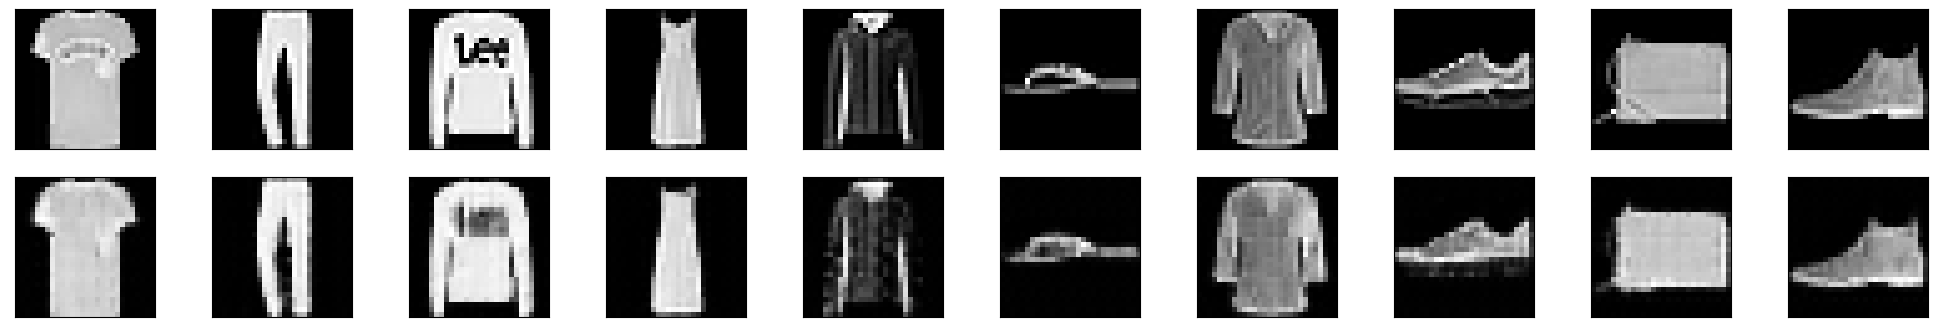

Epoch:  65/128, Training Epoch avg. Loss: 0.005377, Testing Loss: 0.005173
Epoch:  66/128, Training Epoch avg. Loss: 0.005371, Testing Loss: 0.005165
Epoch:  67/128, Training Epoch avg. Loss: 0.005365, Testing Loss: 0.005158
Epoch:  68/128, Training Epoch avg. Loss: 0.005359, Testing Loss: 0.005152
Epoch:  69/128, Training Epoch avg. Loss: 0.005354, Testing Loss: 0.005147
Epoch:  70/128, Training Epoch avg. Loss: 0.005349, Testing Loss: 0.005144
Epoch:  71/128, Training Epoch avg. Loss: 0.005343, Testing Loss: 0.005143
Epoch:  72/128, Training Epoch avg. Loss: 0.005338, Testing Loss: 0.005138
Epoch:  73/128, Training Epoch avg. Loss: 0.005334, Testing Loss: 0.005137
Epoch:  74/128, Training Epoch avg. Loss: 0.005329, Testing Loss: 0.005128
Epoch:  75/128, Training Epoch avg. Loss: 0.005324, Testing Loss: 0.005126
Epoch:  76/128, Training Epoch avg. Loss: 0.005319, Testing Loss: 0.005121
Epoch:  77/128, Training Epoch avg. Loss: 0.005315, Testing Loss: 0.005118
Epoch:  78/128, Training 

In [7]:
# training the auto encoder (pre-train the cnn part of the classifier)
epoch_cnt = 128
for epoch in range(epoch_cnt):
    train_loss = ae_train_epoch(encoder, decoder, device, train_dataloader, ae_loss, ae_optim)
    test_loss = ae_test_epoch(encoder, decoder, device, test_dataloader, ae_loss)

    if epoch % 64 == 0:
        ae_plot(encoder, decoder, test_data, device)
    print(f'Epoch: {(epoch+1):3d}/{epoch_cnt:3d}, Training Epoch avg. Loss: {train_loss:.6f}, Testing Loss: {test_loss:.6f}')

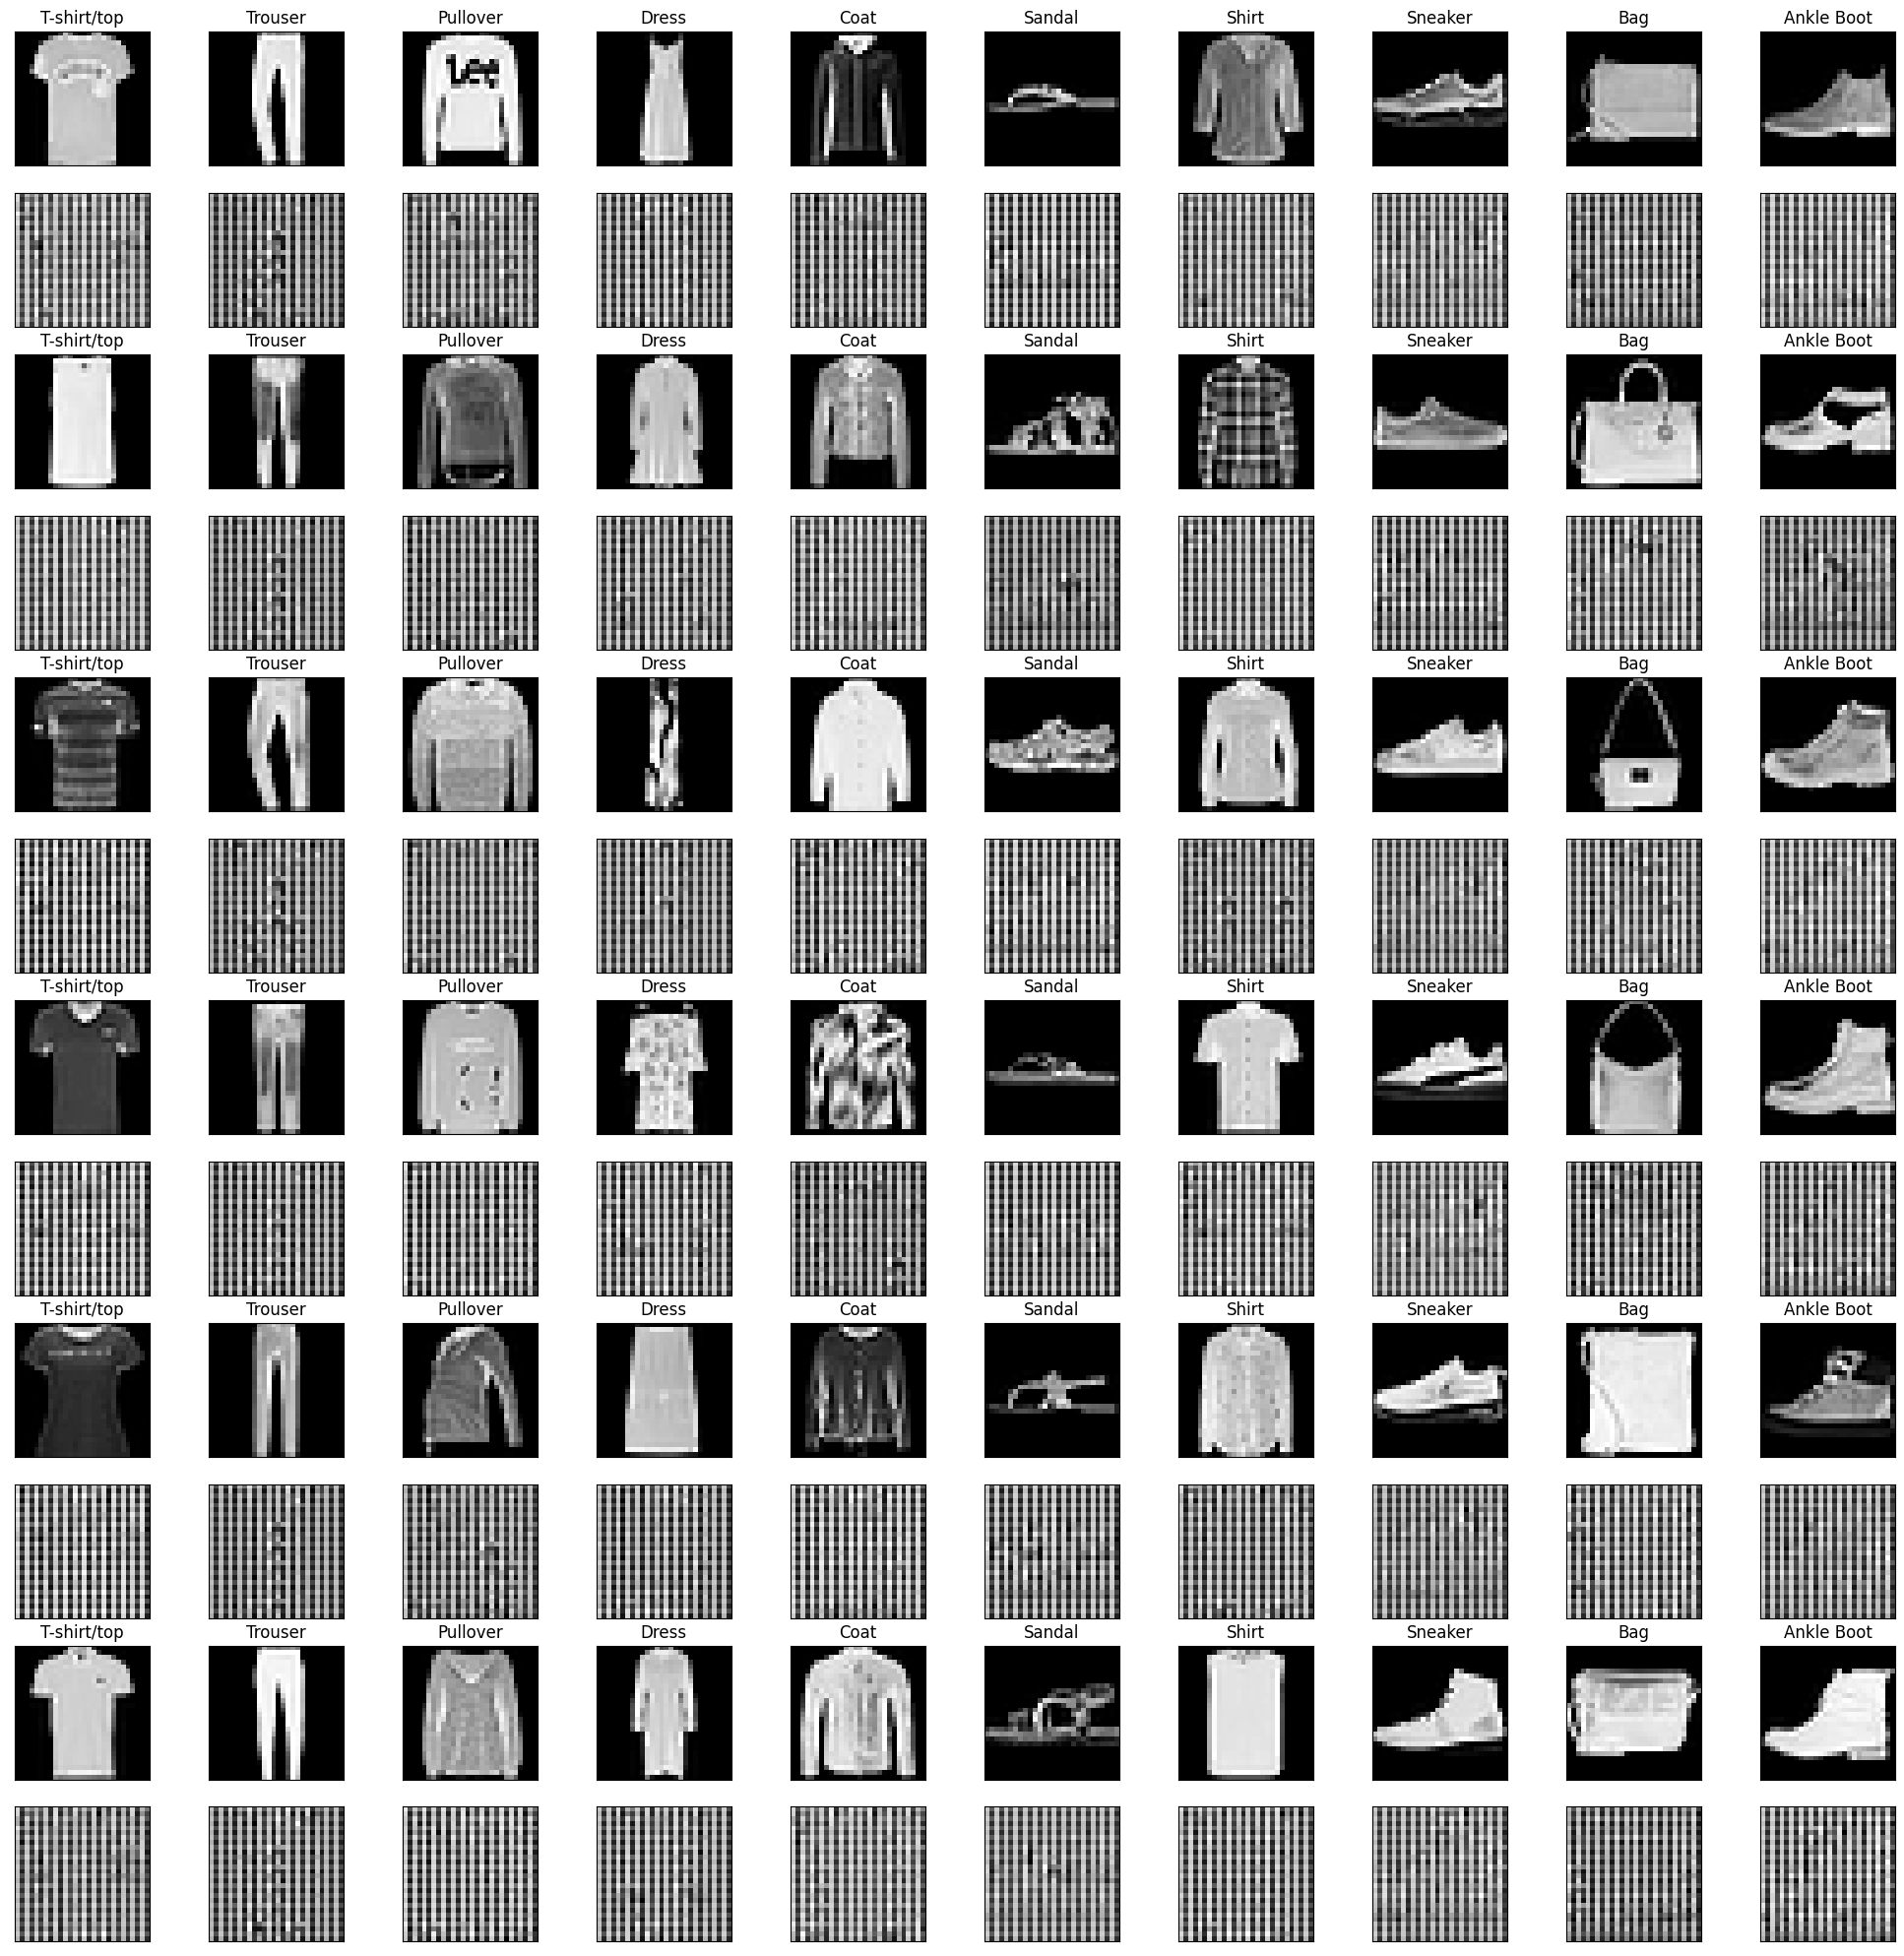

In [57]:
ae_plot(encoder, decoder, test_data, device, 6)

In [9]:
def clf_train_epoch(encoder, model, device, dataloader, loss_fn, optim):
    encoder.train()
    model.train()

    train_loss = []
    accuracy = 0.0
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        coded = encoder(X)
        pred = model(coded)
        loss = loss_fn(pred, y) # since we are using Cross Entropy, no need for softmax

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.detach().cpu().numpy())
        accuracy += (pred.detach().cpu().argmax(1) == y.cpu()).type(torch.float).sum().item()

    test_loss = np.mean(train_loss)
    accuracy /= len(dataloader.dataset)
    return test_loss, accuracy

def clf_test_epoch(encoder, model, device, dataloader, loss_fn):
    encoder.eval()
    model.eval()

    test_loss = []
    accuracy = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(encoder(X))
            loss = loss_fn(pred, y)

            test_loss.append(loss.detach().cpu().numpy())
            accuracy += (pred.detach().cpu().argmax(1) == y.cpu()).type(torch.float).sum().item()
    
    test_loss = np.mean(train_loss)
    accuracy /= len(dataloader.dataset)
    return test_loss, accuracy

In [10]:
clf_params = [
    {'params': encoder.parameters()},
    {'params': classifier.parameters()}
]
clf_loss = torch.nn.CrossEntropyLoss()
clf_optim = torch.optim.Adam(clf_params, lr=learning_rate)

In [14]:
# training classifier
epoch_cnt = 256
for epoch in range(epoch_cnt):
    train_loss, train_acc = clf_train_epoch(encoder, classifier, device, train_dataloader, clf_loss, clf_optim)
    test_loss, test_acc = clf_test_epoch(encoder, classifier, device, test_dataloader, clf_loss)

    print(f'Epoch: {(epoch+1):3d}/{epoch_cnt:3d}, Training Epoch avg. Loss: {train_loss:.6f}, Training Epoch avg. Accuracy: {100*train_acc:5.2f}% Testing Loss: {test_loss:.6f}, Testing Accuracy: {100*test_acc:5.2f}%')

Epoch:   1/256, Training Epoch avg. Loss: 0.117504, Training Epoch avg. Accuracy: 95.34% Testing Loss: 0.117504, Testing Accuracy: 91.76%
Epoch:   2/256, Training Epoch avg. Loss: 0.120758, Training Epoch avg. Accuracy: 95.37% Testing Loss: 0.120758, Testing Accuracy: 91.61%
Epoch:   3/256, Training Epoch avg. Loss: 0.116249, Training Epoch avg. Accuracy: 95.43% Testing Loss: 0.116249, Testing Accuracy: 91.52%
Epoch:   4/256, Training Epoch avg. Loss: 0.117549, Training Epoch avg. Accuracy: 95.29% Testing Loss: 0.117549, Testing Accuracy: 91.76%
Epoch:   5/256, Training Epoch avg. Loss: 0.121523, Training Epoch avg. Accuracy: 95.30% Testing Loss: 0.121523, Testing Accuracy: 91.67%
Epoch:   6/256, Training Epoch avg. Loss: 0.116762, Training Epoch avg. Accuracy: 95.46% Testing Loss: 0.116762, Testing Accuracy: 91.60%
Epoch:   7/256, Training Epoch avg. Loss: 0.119261, Training Epoch avg. Accuracy: 95.39% Testing Loss: 0.119261, Testing Accuracy: 91.84%
Epoch:   8/256, Training Epoch avg

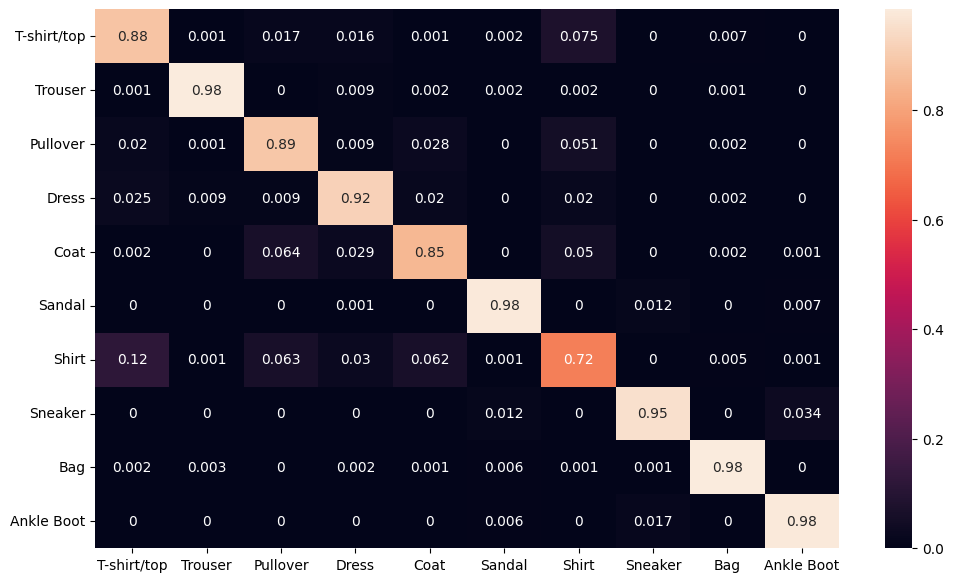

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = classifier(encoder(X))
        y_pred.extend(pred.detach().cpu().argmax(1).numpy())
        y_true.extend(y.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()

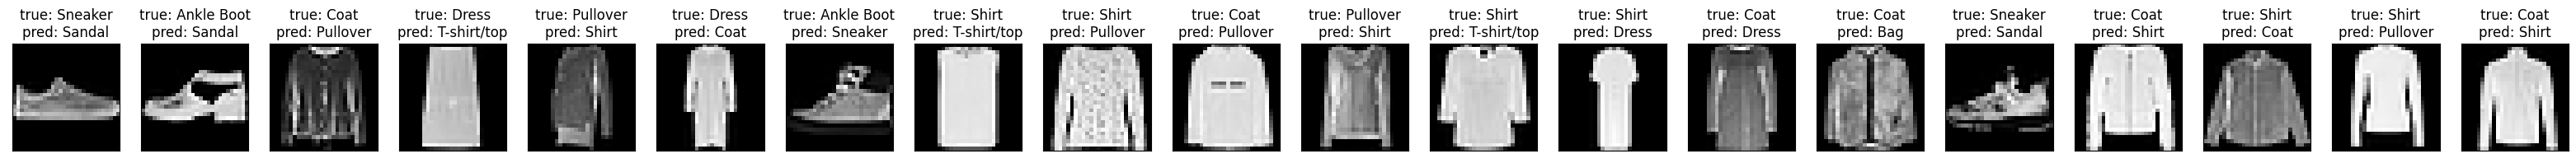

In [61]:
imgs = []
pred_y = []
true_y = []

show_n = 20

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = classifier(encoder(X))
        pred = pred.detach().cpu().argmax(1).numpy()
        y = y.cpu().numpy()

        idx = np.where(pred != y)
        
        img = list(np.squeeze((X.cpu().numpy()[idx])))
        pred = pred[idx]
        y = y[idx]

        imgs.extend(img)
        pred_y.extend(pred)
        true_y.extend(y)
        if len(imgs) >= show_n:
            break

_, axes = plt.subplots(nrows=1, ncols=show_n, sharex=True, sharey=True, figsize=(2*show_n,2.5))
for ax, img, pred, y in zip(axes, imgs, pred_y, true_y):
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true: ' + classes[y]+'\npred: '+classes[pred])

In [16]:
torch.save(encoder.state_dict(), 'encoder_weight.pth')
torch.save(decoder.state_dict(), 'decoder_weight.pth')
torch.save(classifier.state_dict(), 'classifier_weight.pth')